<u>**Making a path based on a polygon**</u>

**I. Create lat, lon positions of outer perimeter** <br>

1. Drive the property and save the data in rosbag
2. Drive around obstacles saving the data
3. Attribute the data into series of sites to cut and obstacles to avoid
4. Determine the center point of the obstacle and the radius of the obstacle avoidance circle

**II. Create Outer Ring Path** <br>

Uplate locations DB with site info.  Open the file below and review each column of data.

In [4]:
# open and review the locations DB
!libreoffice --calc /home/tractor/ros1_lawn_tractor_ws/project_notes/paths/paths_locations.csv

*open the script and update hardcoding*

line 542 - location_name = 'Collins_Dr_62_Site_01'
line 567 & 568 - circle_center = (17.3, -9.1) ; radius = 2.4
line 575 & 576 - lookahead=2.5; speed=0.75
line 570  xy_file_adjusted_for_obstacles - this is out by the process so this should not have to change unless maybe the site changes.
line 571 finished_xy_file - you can leave this alone, just think through if you want to copy this file into the 'ready to test' folder
     = '/home/tractor/ros1_lawn_tractor_ws/project_notes/paths/Collins_Dr_62/Site_01_ring_adjusted_for_obstacles.csv'
    = '/home/tractor/ros1_lawn_tractor_ws/project_notes/paths/input_path.txt' 

In [19]:
import subprocess

# Full path to the subl command and the file you want to open
subl_path = "/snap/bin/subl"
file_path = "/home/tractor/ros1_lawn_tractor_ws/project_notes/code_for_testing/archive/path_polygon_rings/path_ll2xy_2inner_rings_v4.py"

# Running the command
subprocess.run([subl_path, file_path])


CompletedProcess(args=['/snap/bin/subl', '/home/tractor/ros1_lawn_tractor_ws/project_notes/code_for_testing/archive/path_polygon_rings/path_ll2xy_2inner_rings_v4.py'], returncode=0)

Run the script below. It will:<br>
1. Extract the lat/lon data from rosbag files using 'gps_data = convert_gps_to_cartesian(latlon_file_path, origin_lat, origin_lon)'
2. Create inner rings using 'ring_path = create_inner_rings(gps_data, num_inner_rings, path_size, start_point, xy_file_name)'
3. Look for intersections of obstacle using 'intersections, segments, indices, circle_segments = find_intersections_with_circle(xy_file_name, circle_center, radius, num_circle_points, xy_file_adjusted_for_obstacles)'
4. Finish the outer perimiter path (i.e. calc angle, add lookahead and speed) using 'update_df_with_angle_lookahead_speed(xy_file_adjusted_for_obstacles, lookahead, speed, finished_xy_file)'

In [11]:
# run script to create outer rings
!python3 /home/tractor/ros1_lawn_tractor_ws/project_notes/code_for_testing/archive/path_polygon_rings/path_ll2xy_2inner_rings_v4.py
#
# NOTE: There are plots created that are not displayed when running this inside of Jupyter

running script: path_ll2xy_2inner_rings_v4.py
reading file: /home/tractor/ros1_lawn_tractor_ws/project_notes/paths/Collins_Dr_62/Site_01.csv and calculating coordinates
There are 1383 records in gps_data from the .csv file
There are 1383 records in polygon points extracted from gps_data
Original polygon written to file: /home/tractor/ros1_lawn_tractor_ws/project_notes/paths/Collins_Dr_62/Site_01_ring_0.csv
Ring 5 written to file: /home/tractor/ros1_lawn_tractor_ws/project_notes/paths/Collins_Dr_62/Site_01_ring_5.csv
Ring 4 written to file: /home/tractor/ros1_lawn_tractor_ws/project_notes/paths/Collins_Dr_62/Site_01_ring_4.csv
Ring 3 written to file: /home/tractor/ros1_lawn_tractor_ws/project_notes/paths/Collins_Dr_62/Site_01_ring_3.csv
Ring 2 written to file: /home/tractor/ros1_lawn_tractor_ws/project_notes/paths/Collins_Dr_62/Site_01_ring_2.csv
Ring 1 written to file: /home/tractor/ros1_lawn_tractor_ws/project_notes/paths/Collins_Dr_62/Site_01_ring_1.csv
Paths written to /home/tractor

**III. Create Stripe Path**<br>
**Step 1 - Load initial variables**<br>
Read the polygon of the field.  The polygon was originally created by driving the outer bounds of the field and extracting the lat lon from the rosbag file.  After that the ll2xy function was used which included deciding on a reference point that becomes (0, 0) for the map.

In [23]:
#
# INPUT VARIABLES
#
mower_cutting_width = 0.9
original_polygon_file = '/home/tractor/ros1_lawn_tractor_ws/project_notes/paths/Collins_Dr_62/Site_01_ring_5.csv'
#
# File for the first iteration of the Boustrophedon line segments
boustrophedon_line_segments = '/home/tractor/ros1_lawn_tractor_ws/project_notes/paths/Collins_Dr_62/Site_01_boustrophedon_line_segments.csv'
# File for calculating the additional points to make a continuous coverage map
trimmed_file_path = '/home/tractor/ros1_lawn_tractor_ws/project_notes/paths/Collins_Dr_62/Site_01_boustrophedon_line_segments_trimmed.csv'
#
# Input file for adding angles  
file_for_adding_angles = '/home/tractor/ros1_lawn_tractor_ws/project_notes/paths/Collins_Dr_62/Site_01_boustrophedon_line_segments_trimmed_points_1to4_in_sequence.csv'
input_for_generator_program = '/home/tractor/ros1_lawn_tractor_ws/project_notes/paths/Collins_Dr_62/Site_01_boustrophedon_line_segments_input_path_for_generator.txt' 


# Libraries used below
import pandas as pd
import numpy as np
from shapely.geometry import Polygon, LineString, MultiLineString
from shapely.affinity import rotate
from matplotlib import pyplot as plt, patheffects
import os
import csv
import math

import dubins

import time

Making the polygon rings...  I'm looking at /home/tractor/ros1_lawn_tractor_ws/project_notes/code_for_testing/archive/path_polygon_rings/path_ll2xy_2inner_rings_v4.py

It reads a DB '    file_path = '/home/tractor/ros1_lawn_tractor_ws/project_notes/paths/paths_locations.csv'  ' that contains logistacal data about each site (e.g. site name, orgin lat/lon,  


**Step 2 - Read .csv file and plot field**<br>
Read the polygon of the field and display it for visual confirmation

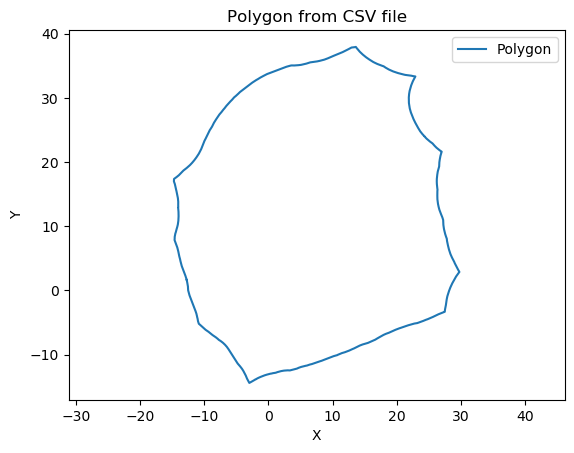

In [9]:


# Read the CSV file
#data = pd.read_csv("/home/tractor/ros1_lawn_tractor_ws/project_notes/paths/Collins_Dr_62/Site_01_ring_5.csv")
data = pd.read_csv(original_polygon_file)

# Extract the X and Y coordinates
x = data["X"].tolist()
y = data["Y"].tolist()

# Close the polygon by adding the first point to the end
x.append(x[0])
y.append(y[0])

# Plot the polygon
plt.plot(x, y, label="Polygon")

# Set labels and title
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Polygon from CSV file")

# Add legend and show plot
plt.legend()
plt.axis('equal')
plt.show()


**Step 3 - Create initial Boustrophedon path**<br>
Create the Boustrophedon line segments that create the starting point for a coverage map.  Adjust the angle for the cut path you prefer.

reading the file:  /home/tractor/ros1_lawn_tractor_ws/project_notes/paths/Collins_Dr_62/Site_01_ring_5.csv
Total line segments: 32


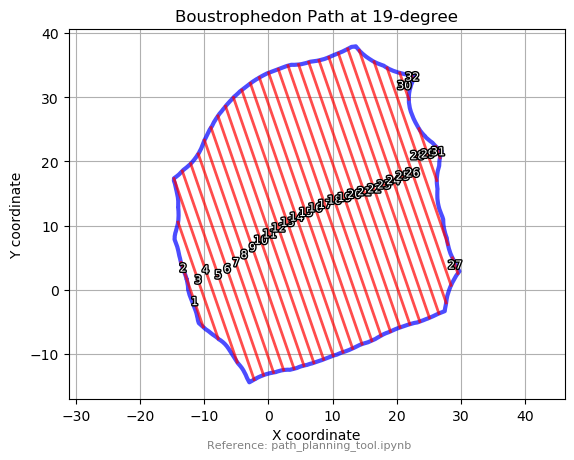

First few lines of boustrophedon line segments
LINESTRING (-10.171175305523374 -5.7874480343457435, -12.827911311739909 1.9282735740213497)
LINESTRING (-12.964071820688654 2.3237124052201534, -13.62973305781336 4.256933010924875)
LINESTRING (-7.839959508785491 -7.615016711301438, -14.086074835081684 10.525019362545644)
LINESTRING (-4.871606894435669 -11.292965064533533, -14.722409531514687 17.31584310790904)
LINESTRING (-2.2361947755906777 -14.003984009101677, -13.42576728037624 18.492894175838853)
eoj


In [24]:
# python3 /home/tractor/ros1_lawn_tractor_ws/project_notes/code_for_testing/archive/boustrophedon/path_boustrophedon_coverage_variable_degree.py

def boustrophedon_path_corrected(polygon, line_spacing, angle_degrees):
    # Normalize the angle to be within -90 to 90 degrees for intersection purposes
    angle_degrees = angle_degrees % 180  # Limit the angle within the 0-180 degree range
    if angle_degrees > 90:
        angle_degrees -= 180  # Convert 91-180 degrees to -89 to -1 degrees

    # Convert the angle from degrees to radians
    angle_radians = np.radians(angle_degrees)
    
    # Rotate the polygon to align the slicing lines with the y-axis
    rotated_polygon = rotate(polygon, -angle_degrees, origin='centroid', use_radians=False)
    minx, miny, maxx, maxy = rotated_polygon.bounds

    # Calculate the length needed for lines to cover the entire area after rotation
    bounding_width = maxx - minx
    bounding_height = maxy - miny
    diag_length = np.sqrt(bounding_width**2 + bounding_height**2)

    # Determine the extended bounds for the lines to ensure they cover the entire rotated polygon area
    extended_bounds = diag_length * np.sqrt(2)
    extended_minx = minx - extended_bounds
    extended_maxx = maxx + extended_bounds
    extended_miny = miny - extended_bounds
    extended_maxy = maxy + extended_bounds

    # Calculate the number of lines needed, considering the line spacing
    num_lines = int(np.ceil(extended_bounds * 2 / (line_spacing * np.cos(angle_radians))))

    path = []
    # Generate lines from one side of the bounding box to the other
    for i in range(num_lines + 1):
        # Calculate the start point of the line
        startx = extended_minx + (line_spacing * np.cos(angle_radians)) * i
        starty = extended_miny
        endx = startx
        endy = extended_maxy
        
        # Create a line that will be rotated to the specified angle
        line = LineString([(startx, starty), (endx, endy)])
        # Rotate the line to the specified angle
        rotated_line = rotate(line, angle_degrees, origin='centroid', use_radians=False)
        # Find the intersection of the rotated line with the original polygon
        intersection = polygon.intersection(rotated_line)
        if not intersection.is_empty:
            # Only consider LineStrings or MultiLineString (ignore Points)
            if isinstance(intersection, LineString):
                path.append(intersection)
            elif isinstance(intersection, MultiLineString):

                # for line in intersection:
                #     path.append(line)

                for line in intersection.geoms:
                    path.append(line)                    


    # Count the total number of line segments excluding the joining segments
    return path, len(path)

# The plot_path function remains the same, now we call it plot_path_corrected
def plot_path(polygon, path_lines, degree):
    fig, ax = plt.subplots()
    x, y = polygon.exterior.xy
    ax.plot(x, y, color='blue', alpha=0.7, linewidth=3, solid_capstyle='round', zorder=2)

    for idx, line in enumerate(path_lines):
        x, y = line.xy
        ax.plot(x, y, color='red', linewidth=2, alpha=0.7, zorder=2)
        # Position the text in the center of the line segment
        text_x = (x[0] + x[1]) / 2
        text_y = (y[0] + y[1]) / 2
        #ax.text(text_x, text_y, str(idx + 1), fontsize=8, verticalalignment='center', horizontalalignment='center')
        ax.text(text_x, text_y, str(idx + 1), fontsize=8, verticalalignment='center',
                horizontalalignment='center', color='white', path_effects=[
                patheffects.withStroke(linewidth=2, foreground="black")])


    ax.set_title(f'Boustrophedon Path at {degree}-degree')
    plt.xlabel('X coordinate')
    plt.ylabel('Y coordinate')
    plt.grid(True)
    plt.axis('equal')
    # Get the absolute path of the current script
    filepath = "path_planning_tool.ipynb"
    plt.figtext(0.5, 0.01, f'Reference: {filepath}', ha='center', fontsize=8, color='gray')
    plt.show()

def write_path_to_csv(path, filename):
    # Open a file for writing
    with open(filename, 'w', newline='') as csvfile:
        # Create a CSV writer object
        csvwriter = csv.writer(csvfile)
        # Write the header
        csvwriter.writerow(['x1', 'y1', 'x2', 'y2'])
        
        # Iterate over the LineStrings in the path
        for linestring in path:
            # For each line, write the start and end coordinates
            start_point, end_point = linestring.coords[:]
            csvwriter.writerow([start_point[0], start_point[1], end_point[0], end_point[1]])


# The main function now correctly handles the angle normalization
def main(angle_degrees):
    print("reading the file: ", original_polygon_file) 
    polygon_data = pd.read_csv(original_polygon_file)
    polygon_points_from_csv = list(zip(polygon_data['X'], polygon_data['Y']))

    polygon = Polygon(polygon_points_from_csv)
    #polygon = Polygon(hard_coded_points)

    # Generate the Boustrophedon path with the corrected angle and line spacing
    #path, num_segments = boustrophedon_path_corrected(polygon, line_spacing=0.9, angle_degrees=angle_degrees)
    line_spacing = mower_cutting_width * 2
    path, num_segments = boustrophedon_path_corrected(polygon, line_spacing, angle_degrees=angle_degrees)
    print(f"Total line segments: {num_segments}")

    # Plot the path
    plot_path(polygon, path, angle_degrees)
    return path

# Run the main function with a corrected angle
path = main(19)
# The .csv output file will be read by plotIntersectingPointsV8.py as input
write_path_to_csv(path, boustrophedon_line_segments)
print("First few lines of boustrophedon line segments")
for point in path[:5]:
    print(point)
print('eoj')

**Step 4 - Trim the initial Boustrophedon path to remove partial segments**<br>
This code defines the input and output file paths, and the number of lines to remove from the beginning and end. It then reads the CSV file line by line, skipping the specified number of lines at the beginning. The remaining lines are stored in a list. Finally, the code iterates through the list and removes the specified number of lines from the end. The trimmed data is then written to a new file with the word "trimmed" added to the original filename.


In [26]:
# Define number of lines to remove from beginning and end
beginning_lines_to_remove = 2
end_lines_to_remove = 6

# Define output file paths
output_file_path = trimmed_file_path

# Read the CSV file
print(f"Reading file: {boustrophedon_line_segments}")
with open(boustrophedon_line_segments, "r") as input_file:
    reader = csv.DictReader(input_file)

    # Skip lines at the beginning
    for _ in range(beginning_lines_to_remove):
        next(reader)

    # Read data and store in a list
    data = list(reader)

    # Remove lines from the end
    data = data[:-end_lines_to_remove]

# Write the trimmed data to a new file
with open(output_file_path, "w") as output_file:
    output_file.truncate(0)  # Clear existing content
    writer = csv.DictWriter(output_file, fieldnames=['x1', 'y1', 'x2', 'y2'])

    # Write header row
    writer.writeheader()

    # Write the data to the output file
    writer.writerows(data)

# Print confirmation message
print(f"Trimmed data saved to: {output_file_path}")


Reading file: /home/tractor/ros1_lawn_tractor_ws/project_notes/paths/Collins_Dr_62/Site_01_boustrophedon_line_segments.csv
Trimmed data saved to: /home/tractor/ros1_lawn_tractor_ws/project_notes/paths/Collins_Dr_62/Site_01_boustrophedon_line_segments_trimmed.csv


**Step 5 - Visualize the coverage map for confirmation**<br>
This code does the following:
* Reads the CSV file and store the data in a list named `data`.
* Extract `x1`, `y1`, `x2`, and `y2` values into separate lists.
* Plot the starting and ending points as colored dots and connect them with line segments.

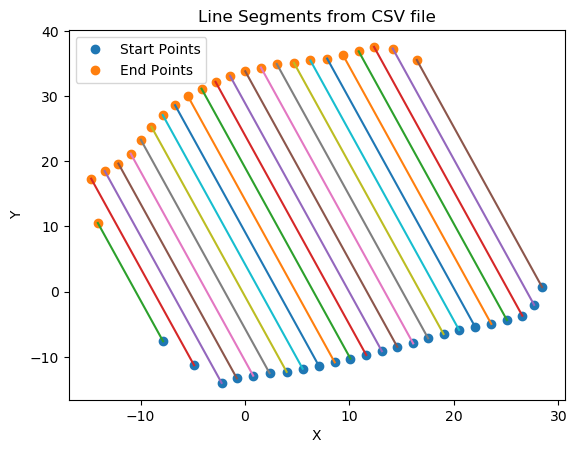

In [27]:
import matplotlib.pyplot as plt

# Read the CSV file
with open(output_file_path, "r") as input_file:
    reader = csv.DictReader(input_file)
    data = list(reader)

# Extract line segment coordinates
x1 = [float(row["x1"]) for row in data]
y1 = [float(row["y1"]) for row in data]
x2 = [float(row["x2"]) for row in data]
y2 = [float(row["y2"]) for row in data]

# Plot line segments
plt.plot(x1, y1, 'o', label='Start Points')
plt.plot(x2, y2, 'o', label='End Points')
for i in range(len(x1)):
    #plt.plot([x1[i], x2[i]], [y1[i], y2[i]], label=f'Segment {i+1}')
    plt.plot([x1[i], x2[i]], [y1[i], y2[i]], label=None)

# Add labels and title
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Line Segments from CSV file")

# Add legend and show plot
plt.legend()
plt.show()


**Step 6 - Visualize how the right angles are calculated**<br>
I need to calculate additional points to define the u-turn points.  This step is actually performed in Step 7.  This particular cell is only for informational purposes so you can see the calculation using hard coded data.

![Desired Path](https://drive.google.com/uc?id=16lBrEnSwtyU9MvEqfyb7ZsiimLvXdoul)


You can see for the'start points', which are at the bottom of the image, I need to calculate the point to the left of the start point. For the 'end points', which are at the top of the image, I need to calculate the point to the right of the end point.  These points make a right triangle.

The very first starting point will be ignored as this is the entry point into the continuous path.  The new bottom point to the left of the original line segment end point will have an x-axis value less than the the original line segment end point x value.  The new top point to the right of the top point will have an x-axis value greater than the the original line segment top point x value.  

The first small script below is simply a test showing how to use two hard coded points to create a third point and to plot it.  You can adjust 'greater' and 'less' to see how the hypotenuse line will shift sides. 


The solution for the hypotenuse is: smaller on the x-axis
The angle 90.0 is within 0.05 degrees of 90 degrees.


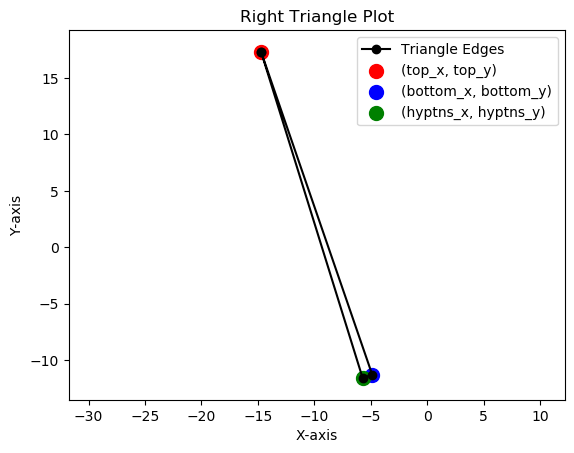

eoj


In [8]:
def calculate_x3_y3_solutions(x1, y1, x2, y2, length=0.9):
    """
    Calculate two possible coordinates of the third point (x3, y3) to form a right triangle
    with the line segment from (x1, y1) to (x3, y3) as the hypotenuse. This function returns
    both solutions, allowing for a choice where x3 can be greater than x2.
    """
    dx = x2 - x1
    dy = y2 - y1

    # Normalize the direction vector (dx, dy)
    norm = np.sqrt(dx**2 + dy**2)
    dx /= norm
    dy /= norm

    # Rotate 90 degrees in both directions and scale by the desired length
    dx1, dy1 = -dy * length, dx * length  # First solution
    dx2, dy2 = dy * length, -dx * length  # Second solution

    # Calculate (x3, y3) for both solutions
    x3_1 = x2 + dx1
    y3_1 = y2 + dy1
    x3_2 = x2 + dx2
    y3_2 = y2 + dy2

    return (x3_1, y3_1), (x3_2, y3_2)

def choose_x3_y3_solution(x2, y2, x3_1, y3_1, x3_2, y3_2, preference='greater'):
    """
    Choose the (x3, y3) point based on the preference.

    Parameters:
    - x3_1, y3_1, x2, y2, x3_2, y3_2: Coordinates of x3 and y3 from the first and second solutions, and x2, y2.
    - preference: Can be 'greater' or 'less' to choose which 'side' the hypothneuse should be on in relation to the x-axis.

    Returns:
    - x3, y3: The chosen coordinates of x3 and y3.
    - solution: A string indicating which solution was chosen.
    """
    if preference == 'greater':
        if x3_1 > x2:
            return x3_1, y3_1, "larger on the x-axis"
        else:
            return x3_2, y3_2, "smaller on the x-axis"
    else:  # preference is 'less'
        if x3_1 < x2:
            return x3_1, y3_1, "larger on the x-axis"
        else:
            return x3_2, y3_2, "smaller on the x-axis"

def angle_check(x1, y1, x2, y2, x3, y3, tolerance=0.05):
    """
    Check if the angle at (x2, y2) is close to 90 degrees within a specified tolerance.
    """
    # Vectors (x1,y1)->(x2,y2) and (x3,y3)->(x2,y2)
    vector1 = [x1 - x2, y1 - y2]
    vector2 = [x3 - x2, y3 - y2]

    # Dot product and magnitudes of vectors
    dot_product = np.dot(vector1, vector2)
    magnitude1 = np.linalg.norm(vector1)
    magnitude2 = np.linalg.norm(vector2)

    # Calculate the angle in degrees
    angle = np.arccos(dot_product / (magnitude1 * magnitude2)) * (180 / np.pi)

    # Check if the angle is within the tolerance of 90 degrees
    if np.abs(angle - 90) > tolerance:
        print(f"Error: The angle {round(angle,2)} is not within 0.1 degrees of 90 degrees.")
    else:
        print(f"The angle {round(angle,2)} is within {tolerance} degrees of 90 degrees.")

def plot_triangle(x1, y1, x2, y2, x3, y3):
    plt.figure()

    # Plot the triangle lines first
    plt.plot([x1, x2, x3, x1], [y1, y2, y3, y1], '-o', color='black', label='Triangle Edges')

    # Set different colors for each point with increased size
    plt.scatter(x1, y1, color='red', s=100, label='(top_x, top_y)')
    plt.scatter(x2, y2, color='blue', s=100, label='(bottom_x, bottom_y)')
    plt.scatter(x3, y3, color='green', s=100, label='(hyptns_x, hyptns_y)')

    # Labels, title, and equal aspect ratio
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.title('Right Triangle Plot')
    plt.legend()
    plt.axis('equal')
    plt.show()

# Test points
top_x, top_y = -14.72, 17.32
bottom_x, bottom_y = -4.87, -11.29

# Calculate both possible (x3, y3) points
(hyptns_x_opt_a, hyptns_y_opt_a), (hyptns_x_opt_b, hyptns_y_opt_b) = calculate_x3_y3_solutions(top_x, top_y, bottom_x, bottom_y)


# Check which solution has x3 greater than x2
hyptns_x, hyptns_y, solution = choose_x3_y3_solution(bottom_x, bottom_y, hyptns_x_opt_a, hyptns_y_opt_a, hyptns_x_opt_b, hyptns_y_opt_b, preference='less')
print(f"The solution for the hypotenuse is: {solution}")

# Check the angle
angle_check(top_x, top_y, bottom_x, bottom_y, hyptns_x, hyptns_y)

# Plot the triangle
plot_triangle(top_x, top_y, bottom_x, bottom_y, hyptns_x, hyptns_y)
print("eoj")
#******************************

**Step 7 - Calculate the additional points to make a continuous coverage map**<br>
Use the approach crafted above to calculate the third point of a right triangle and iterate over the .csv file to calculate all the points in the full set of line segments.   

The overview of the program is:<br>
1. Read the .csv file into a DataFrame<br>
2. Assign the values for (x1, y1), (x2, y2) named (bottom_x, bottom_y), (top_x, top_y)<br>
3. Calculate the hypotenuse for the 'bottom' point<br>
4. Calculate the hypotenuse for the 'top' point<br>
5. Store the points in a DataFrame <br>
6. Move to the next line segment until complete<br>
7. Once the loop is complete write the dataframe to a new .csv file.<br><br>


In [10]:
def calculate_x3_y3_solutions(x1, y1, x2, y2, length=0.9):
    """
    Calculate two possible coordinates of the third point (x3, y3) to form a right triangle
    with the line segment from (x1, y1) to (x3, y3) as the hypotenuse. This function returns
    both solutions, allowing for a choice where x3 can be greater than x2.
    """
    dx = x2 - x1
    dy = y2 - y1

    # Normalize the direction vector (dx, dy)
    norm = np.sqrt(dx**2 + dy**2)
    dx /= norm
    dy /= norm

    # Rotate 90 degrees in both directions and scale by the desired length
    dx1, dy1 = -dy * length, dx * length  # First solution
    dx2, dy2 = dy * length, -dx * length  # Second solution

    # Calculate (x3, y3) for both solutions
    x3_1 = x2 + dx1
    y3_1 = y2 + dy1
    x3_2 = x2 + dx2
    y3_2 = y2 + dy2

    return (x3_1, y3_1), (x3_2, y3_2)

def choose_x3_y3_solution(x2, y2, x3_1, y3_1, x3_2, y3_2, preference='greater'):
    """
    Choose the (x3, y3) point based on the preference.

    Parameters:
    - x3_1, y3_1, x2, y2, x3_2, y3_2: Coordinates of x3 and y3 from the first and second solutions, and x2, y2.
    - preference: Can be 'greater' or 'less' to choose which 'side' the hypothneuse should be on in relation to the x-axis.

    Returns:
    - x3, y3: The chosen coordinates of x3 and y3.
    - solution: A string indicating which solution was chosen.
    """
    if preference == 'greater':
        if x3_1 > x2:
            return x3_1, y3_1, "larger on the x-axis"
        else:
            return x3_2, y3_2, "smaller on the x-axis"
    else:  # preference is 'less'
        if x3_1 < x2:
            return x3_1, y3_1, "larger on the x-axis"
        else:
            return x3_2, y3_2, "smaller on the x-axis"    

# Path to the input CSV file
#input_file_path = '/home/tractor/ros1_lawn_tractor_ws/project_notes/paths/Collins_Dr_62/Site_01_boustrophedon_line_segments_trimmed.csv'
input_file_path = trimmed_file_path

output_file_path = input_file_path.replace(".csv", "_points_1to4.csv") # Create output file path based on the input file path
df = pd.read_csv(input_file_path, header=None, skiprows=1) # Skip the header and the first line segment because it is the entry point
results_df = pd.DataFrame(columns=[
    'Point_1_x', 'Point_1_y', 
    'Point_2_x', 'Point_2_y',
    'Point_3_x', 'Point_3_y', 
    'Point_4_x', 'Point_4_y'    
    ])  # Create an empty DataFrame for storing results

# Iterate over each line segment in the CSV file
for index, row in df.iterrows():
    # get the incoming data
    bottom_x, bottom_y, top_x, top_y = row[:4]  # Assuming the CSV has x1, y1, x2, y2 in this order and x1, y1 is the bottom of the line

    # handle the bottom of the line segment
    (hyptns_x_opt_a, hyptns_y_opt_a), (hyptns_x_opt_b, hyptns_y_opt_b) = calculate_x3_y3_solutions(top_x, top_y, bottom_x, bottom_y)
    pt1_hyptns_x, pt1_hyptns_y, solution = choose_x3_y3_solution(bottom_x, bottom_y, hyptns_x_opt_a, hyptns_y_opt_a, hyptns_x_opt_b, hyptns_y_opt_b, preference='less')

    # handle the top of the line segment
    (hyptns_x_opt_a, hyptns_y_opt_a), (hyptns_x_opt_b, hyptns_y_opt_b) = calculate_x3_y3_solutions(bottom_x, bottom_y, top_x, top_y)
    pt2_hyptns_x, pt2_hyptns_y, solution = choose_x3_y3_solution(top_x, top_y, hyptns_x_opt_a, hyptns_y_opt_a, hyptns_x_opt_b, hyptns_y_opt_b, preference='greater')

    # Store points in the DataFrame
    results_df.loc[index] = [pt1_hyptns_x, pt1_hyptns_y, bottom_x, bottom_y, top_x, top_y, pt2_hyptns_x, pt2_hyptns_y]  
   
results_df.to_csv(output_file_path, index=False)  # Write the results to a new CSV file

print(f"{index} records output to {output_file_path}")
plot_the_path_filename = output_file_path   # used in the next step/Jupyter cell

23 records output to /home/tractor/ros1_lawn_tractor_ws/project_notes/paths/Collins_Dr_62/Site_01_boustrophedon_line_segments_trimmed_points_1to4.csv


Plot the .csv file /home/tractor/ros1_lawn_tractor_ws/project_notes/paths/Collins_Dr_62/Site_01_boustrophedon_line_segments_trimmed_points_1_2.csv


**Step 8 - Plot points for visual verification**<br>
Now I need to plot the points for some visual verification.  The plot shows the connected path of points. For each row in the ,csv file has a sequence of 4 points.  The path will be from Point 1 to Point 2 to Point 3 to Point 4 and is connected by a green line, creating a continuous path that represents the sequence of movements for the entire .csv file.

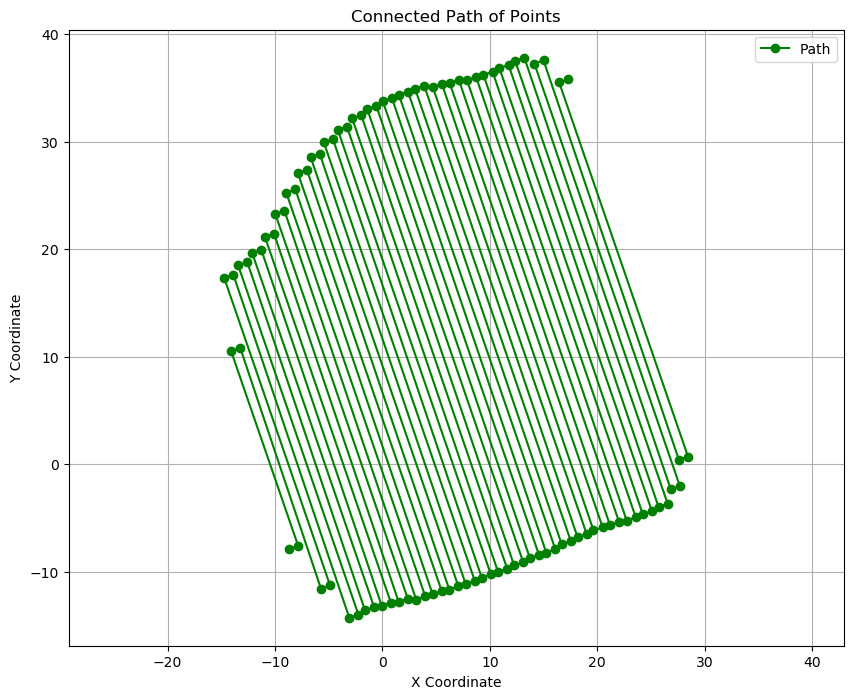

In [14]:
# Load the provided CSV file into a DataFrame
file_path = plot_the_path_filename

df = pd.read_csv(file_path)

# Initialize lists to hold the x and y coordinates in the order of plotting
x_coords = []
y_coords = []

# Loop through the DataFrame and add the coordinates in the required order
for index, row in df.iterrows():
    x_coords.extend([row['Point_1_x'], row['Point_2_x'], row['Point_3_x'], row['Point_4_x']])
    y_coords.extend([row['Point_1_y'], row['Point_2_y'], row['Point_3_y'], row['Point_4_y']])

# Now plot the points and the connecting green line
plt.figure(figsize=(10, 8))

# Plot the red and blue dots for points 1 and 2
# plt.scatter(df['Point_1_x'], df['Point_1_y'], color='red', label='Point 1')
# plt.scatter(df['Point_2_x'], df['Point_2_y'], color='blue', label='Point 2')

# Connect the points with a green line
plt.plot(x_coords, y_coords, 'go-', label='Path')

# Set the x and y axis limits to be equal
plt.axis('equal')

# Add labels and title
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('Connected Path of Points')
plt.legend()
plt.grid(True)
plt.show()

**Step 9 - Reformat the data to prepare for angle calculations**<br>
Now I need to calculate the angle each segment is travelling to be able to use that as input into the path generator routine and then run the path generator routine to create an input file, or a file to save in the "Ready for Testing" folder.  To do that I first need to reformat the 1 row, 4 point x, y data into a series of rows with just one x, y data point on each row.

In [13]:
def reformat_csv(input_file_path, output_file_path):
    df = pd.read_csv(input_file_path)
    reformatted_data = []

    # Iterate over each row and extract each set of x and y coordinates in the specified order
    for index, row in df.iterrows():
        reformatted_data.append([row['Point_1_x'], row['Point_1_y']])
        reformatted_data.append([row['Point_2_x'], row['Point_2_y']])
        reformatted_data.append([row['Point_3_x'], row['Point_3_y']])
        reformatted_data.append([row['Point_4_x'], row['Point_4_y']])

    # Convert the list of lists into a DataFrame
    reformatted_df = pd.DataFrame(reformatted_data, columns=['X', 'Y'])

    # Save the new DataFrame to a CSV file
    reformatted_df.to_csv(output_file_path, index=False)

input_file_path = plot_the_path_filename
output_file_path = input_file_path.replace(".csv", "_in_sequence.csv") # Create output file path based on the input file path

# Call the function to reformat the CSV
reformat_csv(input_file_path, output_file_path)
print(f"list of x, y points ready for angle calculations.  Use {output_file_path} as input")

list of x, y points ready for angle calculations.  Use /home/tractor/ros1_lawn_tractor_ws/project_notes/paths/Collins_Dr_62/Site_01_boustrophedon_line_segments_trimmed_points_1to4_in_sequence.csv as input


**Step 10 - Calculate the angle between points, add  lookahead and speed**<br>
Prepare the data for input into the final generation step by calculating the andgle and add speed and lookahead.

In [9]:
def update_df_with_angle_lookahead_speed(input_file_path, lookahead, speed, output_file_path):
    def calculate_angle(x1, y1, x2, y2):
        '''Calculates the directional angle with respect to the positive X-axis.'''
        angle = math.atan2(y2 - y1, x2 - x1)
        if angle < 0:
            angle += 2 * math.pi
        return angle

    print("calculating angles")
    df = pd.read_csv(input_file_path)

    # Initialize the angles list
    angles = []
    angles.append(0.0)  # First row gets an angle of 0.0
    for idx in range(1, len(df), 2):
        x1, y1 = df.iloc[idx]['X'], df.iloc[idx]['Y']

        # Check if the next index is within the bounds of the DataFrame
        if idx + 1 < len(df):
            x2, y2 = df.iloc[idx + 1]['X'], df.iloc[idx + 1]['Y']
            x2, y2 = df.iloc[idx + 1]['X'], df.iloc[idx + 1]['Y']
            angle = calculate_angle(x1, y1, x2, y2)            
            angles.extend([angle, angle]) 
        #print(f"sub_idx {idx}, x1 {round(df.iloc[idx]['X'], 3)}, y1 {round(df.iloc[idx]['Y'], 3)}, angle {round(angle, 3)}")
    # Ensure that the length of angles matches the DataFrame
    while len(angles) < len(df):
        angles.append(angles[-1])
    print(f"Length of angles list {len(angles)}, length of DataFrame {len(df)}")
    print("adding lookahead and speed")
    df['angle'] = angles
    df['lookahead'] = lookahead
    df['speed'] = speed
    print("writing .csv file")
    df.to_csv(output_file_path, index=False, header=False, sep=' ')
    return

xy_file_adjusted_for_obstacles = file_for_adding_angles
lookahead=2.5
speed=0.75
finished_xy_file = input_for_generator_program

update_df_with_angle_lookahead_speed(xy_file_adjusted_for_obstacles, lookahead, speed, finished_xy_file)
print(f"Data published to file: {finished_xy_file} to be used as input to the generator.py program")


calculating angles
Length of angles list 96, length of DataFrame 96
adding lookahead and speed
writing .csv file
Data published to file: /home/tractor/ros1_lawn_tractor_ws/project_notes/paths/Collins_Dr_62/Site_01_boustrophedon_line_segments_input_path_for_generator.txt to be used as input to the generator.py program


**Step 11 - Generate path using Dubins shortest path**<br>
Read in a series of waypoints from the file waypoint.txt and expand them based on the step size and angle using the Dubins shortest path library.  The practical 
use of this is to have straight segments followed by a u-turn that is shaped like a key hole.

For an explanation for the input file can be found in the document 'Path Planning - Creating a waypoint plan using path_generator.odt' which can be 
found at https://github.com/jones2126/ros1_lawn_tractor_ws


references:
- credit to Matt Droter for an initial outline script
- https://pypi.org/project/dubins/

In [6]:
def generate_path(x0,y0,x1,y1,theta0,theta1,turning_radius,step_size):
    q0 = (x0, y0, theta0)
    q1 = (x1, y1, theta1)
    continuous_path = dubins.shortest_path(q0, q1, turning_radius)
    calculated_path_segment, _ = continuous_path.sample_many(step_size) # takes the continuous Dubins path and samples it at intervals specified by step_size
    return calculated_path_segment
    
def calculate_curvature(p1, p2, p3):
    x1, y1 = p1[0], p1[1]
    x2, y2 = p2[0], p2[1]
    x3, y3 = p3[0], p3[1]

    # Calculate the semi-perimeter
    a = math.sqrt((x1 - x2)**2 + (y1 - y2)**2)
    b = math.sqrt((x2 - x3)**2 + (y2 - y3)**2)
    c = math.sqrt((x3 - x1)**2 + (y3 - y1)**2)
    s = (a + b + c) / 2

    # Check for collinearity or near-collinearity
    area = s * (s - a) * (s - b) * (s - c)
    if area <= 0:
        return 0  # Curvature is zero if the points are collinear

    # Calculate the radius of the circumscribed circle
    radius = a * b * c / (4 * math.sqrt(area))

    # Calculate the curvature
    curvature = 1 / radius if radius != 0 else 0

    return curvature

def calculate_curvature_and_output_csv(drive_path, output_file_curvature_of_waypoints, alternate_lookahead, curvature_threshold):
  
    with open(output_file_curvature_of_waypoints, 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['x', 'y', 'curvature', 'lookahead'])

        for i in range(1, len(drive_path) - 1):
            p1, p2, p3 = drive_path[i - 1], drive_path[i], drive_path[i + 1]
            curvature = calculate_curvature(p1, p2, p3)

            # Update lookahead distance based on curvature
            if curvature > curvature_threshold:
                lookahead = alternate_lookahead
            else:
                lookahead = p2[3]  # Use existing lookahead if curvature is not above threshold

            # Update the tuple in drive_path
            drive_path[i] = (p2[0], p2[1], p2[2], lookahead, p2[4])

            # Write data to CSV
            writer.writerow([p2[0], p2[1], curvature, lookahead])
    print(f"file written with curvature data: {output_file_curvature_of_waypoints}")
    return drive_path 

def main():
    def read_waypoints(input_file_waypoints):
        with open(input_file_waypoints, 'r') as file:
            content = file.readlines()
        return [x.strip() for x in content]

    def generate_drive_path(waypoints, turning_radius, step_size, lookahead, speed):
        drive_path = []
        x0, y0, theta0 = 0.0, 0.0, 0.0
        for idx, line in enumerate(waypoints):
            points = line.split()
            x1, y1, theta1 = map(float, points[:3])
            if idx == 0:
                x0, y0, theta0 = x1, y1, theta1   # For the first line, just set the initial x, y, theta
                continue
            # Generate path from the previous to the current waypoint
            calculated_path_segment = generate_path(x0, y0, x1, y1, theta0, theta1, turning_radius, step_size)
            for segment in calculated_path_segment:
                segment += (lookahead, speed)   # Appending lookahead and speed to each point in the path
                drive_path.append(segment)
            x0, y0, theta0 = x1, y1, theta1     # Updating the start point for the next segment
        return drive_path

    def write_output_file(output_file_waypoints, drive_path):
        total_count = 0
        with open(output_file_waypoints, 'w') as file:
            for p in drive_path:
                total_count += 1
                file.write(f"{p[0]} {p[1]} {p[2]} {p[3]} {p[4]}\n")
        return total_count

    # main routine
    turning_radius=1.3
    step_size=0.3
    lookahead=2.5
    alternate_lookahead=1.0
    curvature_threshold=0.02
    speed=0.75

    working_directory = "/home/tractor/ros1_lawn_tractor_ws/project_notes/paths/Collins_Dr_62/"
    input_file_waypoints = working_directory + "Site_01_boustrophedon_line_segments_input_path_for_generator.txt"
    #/home/tractor/ros1_lawn_tractor_ws/project_notes/paths/Collins_Dr_62/Site_01_boustrophedon_line_segments_input_path_for_generator.txt
    output_file_curvature_of_waypoints = working_directory + "test_PID_curvature_of_waypoints.csv"
    output_file_waypoints = working_directory + "test_generator_output.txt"
    waypoints = read_waypoints(input_file_waypoints)
    drive_path = generate_drive_path(waypoints, turning_radius, step_size, lookahead, speed)    # Process 1: Path Generation
    print("done with generate_drive_path")
    # Call the function to calculate curvature and output to CSV
    drive_path = calculate_curvature_and_output_csv(drive_path, output_file_curvature_of_waypoints, alternate_lookahead, curvature_threshold)
    print("done with calculate_curvature_and_output_csv")
    total_count = write_output_file(output_file_waypoints, drive_path)                          # Process 2: Output File Creation and Data Appending
    print(f"Output file: {output_file_waypoints}")
    print("Record count:", total_count, "turning_radius:", turning_radius, "step_size:", step_size)
    print("eoj")

if __name__ == "__main__":
    main()

done with generate_drive_path
file written with curvature data: /home/tractor/ros1_lawn_tractor_ws/project_notes/paths/Collins_Dr_62/test_PID_curvature_of_waypoints.csv
done with calculate_curvature_and_output_csv
Output file: /home/tractor/ros1_lawn_tractor_ws/project_notes/paths/Collins_Dr_62/test_generator_output.txt
Record count: 7746 turning_radius: 1.3 step_size: 0.3
eoj


THIS STEP RUNS FOR ~ 70 SECONDS on my HP G-645

Plot the path.  Keep the import statement and filename within this function in case you want to copy the code and run it outside of Jupyter.  That will allow me to zoom in on points if need.

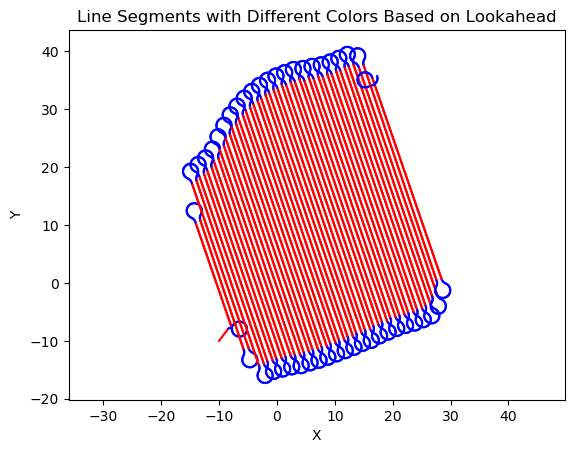

In [5]:
import matplotlib.pyplot as plt

# Function to read data from a file
def read_data(file_path):
    points = []
    with open(file_path, 'r') as file:
        for line in file:
            if line.strip():  # Ignore empty lines
                x, y, theta, lookahead, speed = map(float, line.split())
                points.append((x, y, lookahead))
    return points

# Function to plot the data
def plot_data(points):
    for i in range(len(points) - 1):
        x1, y1, lookahead1 = points[i]
        x2, y2, lookahead2 = points[i + 1]

        # Choose color based on lookahead value
        #color = 'red' if lookahead1 == 2.5 or lookahead2 == 2.5 else 'blue'
        color = 'red' if lookahead1 == 2.5 else 'blue'

        # Plotting the line segment
        plt.plot([x1, x2], [y1, y2], color=color)

    # Set labels and title
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('Line Segments with Different Colors Based on Lookahead')
    plt.axis("equal")
    # Show the plot
    plt.show()

# Main 
file_path = '/home/tractor/ros1_lawn_tractor_ws/project_notes/paths/Collins_Dr_62/test_generator_output.txt'  
data_points = read_data(file_path)
plot_data(data_points)


1. I need to overlay the perimeter runs and integrate the two paths (e.g. the end of the first needs to be the start of the second). <br>I have a program already that plots these.  I need to update the file names.
3. I need to clean up the ending
4. abc

**Open the script and update hardcoding for filepath names**<br>

This is simply a visualization step to review the paths.  The input files have the x, y, theta, lookahead and speed as columns and are therefore ready to be input files to pure_pursuit.cpp

The 'stripe' path is output from <u>Step 11 - Generate path using Dubins shortest path</u> above.  In the Jupyter cell there is a statement 'output_file_waypoints = working_directory + "test_generator_output.txt"' which appends text to the working directory.  The full name is printed when the cell finishes execution.  That name should be used for the 'blue path' filename. 

The ring path is output from script 'path_ll2xy_2inner_rings_v4.py'.  There is a variable 'finished_xy_file' that defines this file.  So whatever name is used there should be used for the 'green path' filename.

In [21]:
import subprocess

# Full path to the subl command and the file you want to open
subl_path = "/snap/bin/subl"
file_path = "/home/tractor/ros1_lawn_tractor_ws/project_notes/code_for_testing/archive/boustrophedon/path_test_plot_before_running_simulation.py"

# Running the command
subprocess.run([subl_path, file_path])

CompletedProcess(args=['/snap/bin/subl', '/home/tractor/ros1_lawn_tractor_ws/project_notes/code_for_testing/archive/boustrophedon/path_test_plot_before_running_simulation.py'], returncode=0)

Running the program: python3 /home/tractor/ros1_lawn_tractor_ws/project_notes/code_for_testing/archive/boustrophedon/path_test_plot_before_running_simulation.py
<br>
Generates the following map: <br><br>
![Incorrect Overlay](https://drive.google.com/uc?id=1rHrDPdMz7_RZwtQR3S_FCPUzPz1pdej8)
<br>
Consider the following changes:
1. Four of the stripes need to be shortened to avoid the obstacle circle
2. Where the blue and green lines overlap is 'waste' in that it would lead to going over the same path twice.  I'm thinking you only run the two most outer rings and add more stripes to eliminate the white space.
3. Stripes can be added to the beginning and end to reduce the white space<br> The file boustrophedon_line_segments is created in Step 3.  You cannot simply go back to <u>Step 4 - Trim the initial Boustrophedon path to remove partial segments</u> and adjust the lines to be trimmed. Step 3 uses the 5th ring as input to create the line segments and for some reason it does not believe there is a lot of white space that is unobstructed.  